# PySpark - Работа с Spark SQL

## Введение в Spark SQL
Spark SQL - это модуль для работы со структурированными данными в Apache Spark. Он предоставляет программный интерфейс для запросов к данным, используя SQL или DataFrame API. В этом ноутбуке мы рассмотрим основные концепции и операции Spark SQL в PySpark.

## Содержание
1. Инициализация Spark и создание SparkSession
2. Создание и регистрация временных представлений
3. Выполнение SQL-запросов
4. Работа с таблицами и базами данных
5. Преобразование между SQL и DataFrame API
6. Работа с пользовательскими функциями в SQL
7. Кэширование и оптимизация SQL-запросов
8. Практические примеры


## 1. Инициализация Spark и создание SparkSession


In [1]:
import findspark
findspark.init()

In [2]:

# Импорт необходимых библиотек
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline


In [3]:
# Создание SparkSession
spark = (SparkSession
    .builder
    .appName("Spark SQL Practice")
    .master("local[*]")
    .getOrCreate()
)

# Проверка версии Spark
print(f"Spark Version: {spark.version}")


Spark Version: 3.0.3



## 2. Создание и регистрация временных представлений
Для использования SQL-запросов в Spark необходимо создать и зарегистрировать временные представления данных.


### Создание данных для примера

In [4]:

# Создание файла с данными о сотрудниках
employees_data = """
id,name,age,department,salary
1,John,30,IT,65000
2,Alice,25,HR,55000
3,Bob,40,Finance,70000
4,Carol,35,IT,68000
5,David,45,Marketing,60000
6,Eva,28,HR,52000
7,Frank,50,Finance,75000
8,Grace,33,Marketing,62000
9,Henry,31,IT,67000
10,Ivy,27,HR,54000
"""

with open("employees.csv", "w") as f:
    f.write(employees_data)

# Создание файла с данными об отделах
departments_data = """
dept_id,dept_name,location,budget
IT,Information Technology,Building A,500000
HR,Human Resources,Building B,300000
Finance,Finance Department,Building A,450000
Marketing,Marketing Department,Building C,400000
Sales,Sales Department,Building C,350000
"""

with open("departments.csv", "w") as f:
    f.write(departments_data)


In [5]:
!hadoop fs -put -f employees.csv /user/ubuntu/employees.csv
!hadoop fs -put -f departments.csv /user/ubuntu/departments.csv

### Чтение данных в DataFrame


In [6]:
# Чтение данных о сотрудниках
employees_df = spark.read.csv("employees.csv", header=True, inferSchema=True)
employees_df.show()


+---+-----+---+----------+------+
| id| name|age|department|salary|
+---+-----+---+----------+------+
|  1| John| 30|        IT| 65000|
|  2|Alice| 25|        HR| 55000|
|  3|  Bob| 40|   Finance| 70000|
|  4|Carol| 35|        IT| 68000|
|  5|David| 45| Marketing| 60000|
|  6|  Eva| 28|        HR| 52000|
|  7|Frank| 50|   Finance| 75000|
|  8|Grace| 33| Marketing| 62000|
|  9|Henry| 31|        IT| 67000|
| 10|  Ivy| 27|        HR| 54000|
+---+-----+---+----------+------+



In [7]:
# Чтение данных о отделах
departments_df = spark.read.csv("departments.csv", header=True, inferSchema=True)
departments_df.show()


+---------+--------------------+----------+------+
|  dept_id|           dept_name|  location|budget|
+---------+--------------------+----------+------+
|       IT|Information Techn...|Building A|500000|
|       HR|     Human Resources|Building B|300000|
|  Finance|  Finance Department|Building A|450000|
|Marketing|Marketing Department|Building C|400000|
|    Sales|    Sales Department|Building C|350000|
+---------+--------------------+----------+------+



### Регистрация временных представлений


In [8]:
# Регистрация DataFrame как временное представление
employees_df.createOrReplaceTempView("employees")
departments_df.createOrReplaceTempView("departments")

In [9]:
# Альтернативный способ - создание глобального временного представления
employees_df.createOrReplaceGlobalTempView("global_employees")

In [10]:
# Проверка регистрации временных представлений
print("Временные представления:")
print(spark.catalog.listTables())


Временные представления:
[Table(name='departments', database=None, description=None, tableType='TEMPORARY', isTemporary=True), Table(name='employees', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]


## 3. Выполнение SQL-запросов

### Базовые SQL-запросы


In [11]:
# Простой SELECT запрос
result = spark.sql("SELECT * FROM employees LIMIT 5")
result.show()

+---+-----+---+----------+------+
| id| name|age|department|salary|
+---+-----+---+----------+------+
|  1| John| 30|        IT| 65000|
|  2|Alice| 25|        HR| 55000|
|  3|  Bob| 40|   Finance| 70000|
|  4|Carol| 35|        IT| 68000|
|  5|David| 45| Marketing| 60000|
+---+-----+---+----------+------+



In [12]:
# SELECT с фильтрацией
result = spark.sql("""
SELECT name, age, department, salary 
FROM employees 
WHERE age > 30 AND salary > 60000
""")
result.show()


+-----+---+----------+------+
| name|age|department|salary|
+-----+---+----------+------+
|  Bob| 40|   Finance| 70000|
|Carol| 35|        IT| 68000|
|Frank| 50|   Finance| 75000|
|Grace| 33| Marketing| 62000|
|Henry| 31|        IT| 67000|
+-----+---+----------+------+



In [13]:
# Агрегирование данных
result = spark.sql("""
SELECT 
    department, COUNT(*) as employee_count, 
    AVG(salary) as avg_salary, 
    MAX(salary) as max_salary, 
    MIN(salary) as min_salary
FROM employees
GROUP BY department
ORDER BY avg_salary DESC
""")
result.show()


+----------+--------------+------------------+----------+----------+
|department|employee_count|        avg_salary|max_salary|min_salary|
+----------+--------------+------------------+----------+----------+
|   Finance|             2|           72500.0|     75000|     70000|
|        IT|             3| 66666.66666666667|     68000|     65000|
| Marketing|             2|           61000.0|     62000|     60000|
|        HR|             3|53666.666666666664|     55000|     52000|
+----------+--------------+------------------+----------+----------+



### Соединение таблиц


In [14]:

# JOIN запрос
result = spark.sql("""
SELECT e.name, e.age, e.salary, 
       d.dept_name, d.location, d.budget
FROM employees e
JOIN departments d ON e.department = d.dept_id
""")
result.show()


+-----+---+------+--------------------+----------+------+
| name|age|salary|           dept_name|  location|budget|
+-----+---+------+--------------------+----------+------+
|Henry| 31| 67000|Information Techn...|Building A|500000|
|Carol| 35| 68000|Information Techn...|Building A|500000|
| John| 30| 65000|Information Techn...|Building A|500000|
|  Ivy| 27| 54000|     Human Resources|Building B|300000|
|  Eva| 28| 52000|     Human Resources|Building B|300000|
|Alice| 25| 55000|     Human Resources|Building B|300000|
|Frank| 50| 75000|  Finance Department|Building A|450000|
|  Bob| 40| 70000|  Finance Department|Building A|450000|
|Grace| 33| 62000|Marketing Department|Building C|400000|
|David| 45| 60000|Marketing Department|Building C|400000|
+-----+---+------+--------------------+----------+------+



In [15]:

# LEFT JOIN
result = spark.sql("""
SELECT e.name, e.department, d.dept_name, d.location
FROM employees e
LEFT JOIN departments d ON e.department = d.dept_id
""")
result.show()


+-----+----------+--------------------+----------+
| name|department|           dept_name|  location|
+-----+----------+--------------------+----------+
| John|        IT|Information Techn...|Building A|
|Alice|        HR|     Human Resources|Building B|
|  Bob|   Finance|  Finance Department|Building A|
|Carol|        IT|Information Techn...|Building A|
|David| Marketing|Marketing Department|Building C|
|  Eva|        HR|     Human Resources|Building B|
|Frank|   Finance|  Finance Department|Building A|
|Grace| Marketing|Marketing Department|Building C|
|Henry|        IT|Information Techn...|Building A|
|  Ivy|        HR|     Human Resources|Building B|
+-----+----------+--------------------+----------+




### Подзапросы и представления


In [16]:

# Использование подзапроса
result = spark.sql("""
SELECT *
FROM (
    SELECT 
        name, age, department, salary,
        RANK() OVER (PARTITION BY department ORDER BY salary DESC) as rank
    FROM employees
) ranked
WHERE rank <= 2
""")
result.show()


+-----+---+----------+------+----+
| name|age|department|salary|rank|
+-----+---+----------+------+----+
|Alice| 25|        HR| 55000|   1|
|  Ivy| 27|        HR| 54000|   2|
|Frank| 50|   Finance| 75000|   1|
|  Bob| 40|   Finance| 70000|   2|
|Grace| 33| Marketing| 62000|   1|
|David| 45| Marketing| 60000|   2|
|Carol| 35|        IT| 68000|   1|
|Henry| 31|        IT| 67000|   2|
+-----+---+----------+------+----+



In [17]:

# Создание и использование представления
spark.sql("""
CREATE OR REPLACE TEMPORARY VIEW high_salary_employees AS
SELECT * FROM employees WHERE salary > 65000
""")

result = spark.sql("SELECT * FROM high_salary_employees")
result.show()


+---+-----+---+----------+------+
| id| name|age|department|salary|
+---+-----+---+----------+------+
|  3|  Bob| 40|   Finance| 70000|
|  4|Carol| 35|        IT| 68000|
|  7|Frank| 50|   Finance| 75000|
|  9|Henry| 31|        IT| 67000|
+---+-----+---+----------+------+



In [18]:
### Доступ к глобальным временным представлениям

# Доступ к глобальному временному представлению
result = spark.sql("SELECT * FROM global_temp.global_employees LIMIT 3")
result.show()


+---+-----+---+----------+------+
| id| name|age|department|salary|
+---+-----+---+----------+------+
|  1| John| 30|        IT| 65000|
|  2|Alice| 25|        HR| 55000|
|  3|  Bob| 40|   Finance| 70000|
+---+-----+---+----------+------+




## 4. Работа с таблицами и базами данных

### Создание базы данных


In [19]:

# Создание базы данных
spark.sql("CREATE DATABASE IF NOT EXISTS company")

# Просмотр баз данных
print("Базы данных:")
spark.sql("SHOW DATABASES").show()


Базы данных:
+---------+
|namespace|
+---------+
|  company|
|  default|
+---------+



### Создание постоянных таблиц

In [20]:
# Создание постоянной таблицы
spark.sql("""
CREATE TABLE IF NOT EXISTS company.employees (
    id INT,
    name STRING,
    age INT,
    department STRING,
    salary INT
)
""")

# Запись данных в таблицу
employees_df.write.mode("overwrite").saveAsTable("company.employees")

# Создание еще одной таблицы
departments_df.write.mode("overwrite").saveAsTable("company.departments")

# Просмотр таблиц в базе данных
print("Таблицы в базе данных company:")
spark.sql("SHOW TABLES IN company").show()


Таблицы в базе данных company:
+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| company|         departments|      false|
| company|           employees|      false|
|        |         departments|       true|
|        |           employees|       true|
|        |high_salary_emplo...|       true|
+--------+--------------------+-----------+



### Запросы к постоянным таблицам

In [21]:
# Запрос к постоянной таблице
result = spark.sql("""
SELECT e.name, e.department, d.location
FROM company.employees e
JOIN company.departments d ON e.department = d.dept_id
WHERE e.salary > 60000
""")
result.show()


+-----+----------+----------+
| name|department|  location|
+-----+----------+----------+
| John|        IT|Building A|
|  Bob|   Finance|Building A|
|Carol|        IT|Building A|
|Frank|   Finance|Building A|
|Grace| Marketing|Building C|
|Henry|        IT|Building A|
+-----+----------+----------+




### Метаданные таблиц и столбцов


In [22]:

# Просмотр метаданных таблицы
print("Метаданные таблицы:")
spark.sql("DESCRIBE TABLE company.employees").show()


Метаданные таблицы:
+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|        id|      int|   null|
|      name|   string|   null|
|       age|      int|   null|
|department|   string|   null|
|    salary|      int|   null|
+----------+---------+-------+



In [23]:

# Просмотр расширенных метаданных
print("Расширенные метаданные:")
spark.sql("DESCRIBE EXTENDED company.employees").show(truncate=False)


Расширенные метаданные:
+----------------------------+---------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                |comment|
+----------------------------+---------------------------------------------------------------------------------------------------------+-------+
|id                          |int                                                                                                      |null   |
|name                        |string                                                                                                   |null   |
|age                         |int                                                                                                      |null   |
|department                  |string                                                                      


## 5. Преобразование между SQL и DataFrame API
Spark SQL и DataFrame API тесно интегрированы, что позволяет легко переходить от одного к другому.

### От SQL к DataFrame


In [24]:
# Выполнение SQL-запроса и преобразование результата в DataFrame
dept_stats_df = spark.sql("""
SELECT 
    department, COUNT(*) as employee_count, 
    ROUND(AVG(salary), 2) as avg_salary
FROM employees
GROUP BY department
ORDER BY avg_salary DESC
""")

# Работа с полученным DataFrame
dept_stats_df.show()


+----------+--------------+----------+
|department|employee_count|avg_salary|
+----------+--------------+----------+
|   Finance|             2|   72500.0|
|        IT|             3|  66666.67|
| Marketing|             2|   61000.0|
|        HR|             3|  53666.67|
+----------+--------------+----------+



In [25]:
dept_stats_df.printSchema()


root
 |-- department: string (nullable = true)
 |-- employee_count: long (nullable = false)
 |-- avg_salary: double (nullable = true)



In [26]:

# Применение дополнительных операций DataFrame
dept_stats_df_extended = dept_stats_df.withColumn(
    "salary_category", 
    when(col("avg_salary") > 65000, "High")
    .when(col("avg_salary") > 55000, "Medium")
    .otherwise("Low")
)
dept_stats_df_extended.show()


+----------+--------------+----------+---------------+
|department|employee_count|avg_salary|salary_category|
+----------+--------------+----------+---------------+
|   Finance|             2|   72500.0|           High|
|        IT|             3|  66666.67|           High|
| Marketing|             2|   61000.0|         Medium|
|        HR|             3|  53666.67|            Low|
+----------+--------------+----------+---------------+




### От DataFrame к SQL


In [27]:

# Создание DataFrame
data = [(1, "Product A", 100, 15.5), (2, "Product B", 200, 10.0), 
        (3, "Product C", 150, 20.0), (4, "Product D", 80, 25.5)]
columns = ["id", "name", "stock", "price"]
products_df = spark.createDataFrame(data, columns)


In [28]:

# Регистрация DataFrame как временного представления
products_df.createOrReplaceTempView("products")


In [29]:

# Выполнение SQL-запроса к представлению
result = spark.sql("""
SELECT name, stock, price, stock * price as inventory_value
FROM products
ORDER BY inventory_value DESC
""")
result.show()


+---------+-----+-----+---------------+
|     name|stock|price|inventory_value|
+---------+-----+-----+---------------+
|Product C|  150| 20.0|         3000.0|
|Product D|   80| 25.5|         2040.0|
|Product B|  200| 10.0|         2000.0|
|Product A|  100| 15.5|         1550.0|
+---------+-----+-----+---------------+




## 6. Работа с пользовательскими функциями в SQL

### Регистрация UDF в SQL


In [30]:

# Определение пользовательской функции Python
def calculate_tax(salary):
    if salary < 60000:
        return salary * 0.15
    else:
        return salary * 0.2

# Регистрация UDF для использования в SQL
spark.udf.register("calculate_tax", calculate_tax, DoubleType())


<function __main__.calculate_tax(salary)>

In [31]:

# Использование UDF в SQL-запросе
result = spark.sql("""
SELECT 
    name, salary, calculate_tax(salary) as tax,
    salary - calculate_tax(salary) as net_salary
FROM employees
ORDER BY salary DESC
""")
result.show()


+-----+------+-------+----------+
| name|salary|    tax|net_salary|
+-----+------+-------+----------+
|Frank| 75000|15000.0|   60000.0|
|  Bob| 70000|14000.0|   56000.0|
|Carol| 68000|13600.0|   54400.0|
|Henry| 67000|13400.0|   53600.0|
| John| 65000|13000.0|   52000.0|
|Grace| 62000|12400.0|   49600.0|
|David| 60000|12000.0|   48000.0|
|Alice| 55000| 8250.0|   46750.0|
|  Ivy| 54000| 8100.0|   45900.0|
|  Eva| 52000| 7800.0|   44200.0|
+-----+------+-------+----------+




### Использование встроенных функций SQL


In [32]:

# Использование встроенных функций в SQL
result = spark.sql("""
SELECT 
    name,
    UPPER(name) as upper_name,
    SUBSTRING(name, 1, 1) as first_letter,
    length(name) as name_length,
    CASE 
        WHEN age < 30 THEN 'Young'
        WHEN age < 40 THEN 'Mid-career'
        ELSE 'Experienced'
    END as age_category
FROM employees
""")
result.show()


+-----+----------+------------+-----------+------------+
| name|upper_name|first_letter|name_length|age_category|
+-----+----------+------------+-----------+------------+
| John|      JOHN|           J|          4|  Mid-career|
|Alice|     ALICE|           A|          5|       Young|
|  Bob|       BOB|           B|          3| Experienced|
|Carol|     CAROL|           C|          5|  Mid-career|
|David|     DAVID|           D|          5| Experienced|
|  Eva|       EVA|           E|          3|       Young|
|Frank|     FRANK|           F|          5| Experienced|
|Grace|     GRACE|           G|          5|  Mid-career|
|Henry|     HENRY|           H|          5|  Mid-career|
|  Ivy|       IVY|           I|          3|       Young|
+-----+----------+------------+-----------+------------+




## 7. Кэширование и оптимизация SQL-запросов

### Кэширование таблиц и представлений


In [ ]:
# Кэширование таблицы
spark.sql("CACHE TABLE employees")

# Проверка кэшированных таблиц
print("Кэшированные таблицы:")
spark.sql("SHOW TABLES").filter("isTemporary = true").show()


Кэшированные таблицы:
+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|        |         departments|       true|
|        |           employees|       true|
|        |high_salary_emplo...|       true|
|        |            products|       true|
+--------+--------------------+-----------+



In [ ]:
# Выполнение запроса к кэшированной таблице
result = spark.sql("""
SELECT department, COUNT(*) as count, AVG(salary) as avg_salary
FROM employees
GROUP BY department
""")
result.show()


+----------+-----+------------------+
|department|count|        avg_salary|
+----------+-----+------------------+
|        HR|    3|53666.666666666664|
|   Finance|    2|           72500.0|
| Marketing|    2|           61000.0|
|        IT|    3| 66666.66666666667|
+----------+-----+------------------+



In [35]:

# Очистка кэша конкретной таблицы
spark.sql("UNCACHE TABLE IF EXISTS employees")


DataFrame[]

### План выполнения запроса

In [36]:


# Получение плана выполнения запроса
query = """
SELECT e.name, e.department, e.salary, d.location
FROM employees e
JOIN departments d ON e.department = d.dept_id
WHERE e.salary > 60000
ORDER BY e.salary DESC
"""

# Вывод логического плана
print("Логический план запроса:")
spark.sql(query).explain()


Логический план запроса:
== Physical Plan ==
*(3) Sort [salary#20 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(salary#20 DESC NULLS LAST, 200), true, [id=#607]
   +- *(2) Project [name#17, department#19, salary#20, location#70]
      +- *(2) BroadcastHashJoin [department#19], [dept_id#68], Inner, BuildRight
         :- *(2) Project [name#17, department#19, salary#20]
         :  +- *(2) Filter ((isnotnull(salary#20) AND (salary#20 > 60000)) AND isnotnull(department#19))
         :     +- FileScan csv [name#17,department#19,salary#20] Batched: false, DataFilters: [isnotnull(salary#20), (salary#20 > 60000), isnotnull(department#19)], Format: CSV, Location: InMemoryFileIndex[hdfs://rc1a-dataproc-m-0fa9b8a28plge0fb.mdb.yandexcloud.net/user/ubuntu/employe..., PartitionFilters: [], PushedFilters: [IsNotNull(salary), GreaterThan(salary,60000), IsNotNull(department)], ReadSchema: struct<name:string,department:string,salary:int>
         +- BroadcastExchange HashedRelationBroadcastMo

In [37]:

# Вывод расширенного плана с физическим планом
print("\nРасширенный план запроса:")
spark.sql(query).explain(extended=True)



Расширенный план запроса:
== Parsed Logical Plan ==
'Sort ['e.salary DESC NULLS LAST], true
+- 'Project ['e.name, 'e.department, 'e.salary, 'd.location]
   +- 'Filter ('e.salary > 60000)
      +- 'Join Inner, ('e.department = 'd.dept_id)
         :- 'SubqueryAlias e
         :  +- 'UnresolvedRelation [employees]
         +- 'SubqueryAlias d
            +- 'UnresolvedRelation [departments]

== Analyzed Logical Plan ==
name: string, department: string, salary: int, location: string
Sort [salary#20 DESC NULLS LAST], true
+- Project [name#17, department#19, salary#20, location#70]
   +- Filter (salary#20 > 60000)
      +- Join Inner, (department#19 = dept_id#68)
         :- SubqueryAlias e
         :  +- SubqueryAlias employees
         :     +- Relation[id#16,name#17,age#18,department#19,salary#20] csv
         +- SubqueryAlias d
            +- SubqueryAlias departments
               +- Relation[dept_id#68,dept_name#69,location#70,budget#71] csv

== Optimized Logical Plan ==
Sort [salar

## 8. Практические примеры

### Пример 1: Анализ продаж с использованием Spark SQL


In [38]:

# Создание файла с данными о продажах
sales_data = """
date,store_id,product_id,quantity,revenue
2023-01-01,1,101,5,250.00
2023-01-01,1,102,3,150.00
2023-01-01,2,101,4,200.00
2023-01-02,1,103,2,100.00
2023-01-02,2,102,5,250.00
2023-01-02,3,101,3,150.00
2023-01-03,1,101,6,300.00
2023-01-03,2,103,4,200.00
2023-01-03,3,102,3,150.00
2023-01-04,1,102,4,200.00
2023-01-04,2,101,5,250.00
2023-01-05,3,103,6,300.00
"""

with open("sales.csv", "w") as f:
    f.write(sales_data)

# Создание файла с информацией о магазинах
stores_data = """
store_id,store_name,region
1,Downtown Store,East
2,Mall Store,West
3,Suburban Store,North
"""

with open("stores.csv", "w") as f:
    f.write(stores_data)

# Создание файла с информацией о продуктах
products_data = """
product_id,product_name,category,unit_price
101,Laptop,Electronics,500.00
102,Smartphone,Electronics,400.00
103,Headphones,Accessories,150.00
"""

with open("products.csv", "w") as f:
    f.write(products_data)


In [39]:
# Чтение данных в DataFrame
sales_df = spark.read.csv("sales.csv", header=True, inferSchema=True)
stores_df = spark.read.csv("stores.csv", header=True, inferSchema=True)
products_df = spark.read.csv("products.csv", header=True, inferSchema=True)


In [40]:
# Регистрация DataFrame как временных представлений
sales_df.createOrReplaceTempView("sales")
stores_df.createOrReplaceTempView("stores")
products_df.createOrReplaceTempView("products")


In [41]:
# Анализ продаж с использованием SQL
# 1. Общие продажи по дням
daily_sales = spark.sql("""
SELECT date, SUM(quantity) as total_quantity, SUM(revenue) as total_revenue
FROM sales
GROUP BY date
ORDER BY date
""")

daily_sales.show()


+----------+--------------+-------------+
|      date|total_quantity|total_revenue|
+----------+--------------+-------------+
|2023-01-01|            12|        600.0|
|2023-01-02|            10|        500.0|
|2023-01-03|            13|        650.0|
|2023-01-04|             9|        450.0|
|2023-01-05|             6|        300.0|
+----------+--------------+-------------+



In [42]:
# 2. Продажи по категориям продуктов
category_sales = spark.sql("""
SELECT p.category, SUM(s.quantity) as total_quantity, SUM(s.revenue) as total_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
""")

category_sales.show()


+-----------+--------------+-------------+
|   category|total_quantity|total_revenue|
+-----------+--------------+-------------+
|Electronics|            38|       1900.0|
|Accessories|            12|        600.0|
+-----------+--------------+-------------+



In [43]:
# 3. Продажи по регионам и категориям
region_category_sales = spark.sql("""
SELECT st.region, p.category, 
       SUM(s.quantity) as total_quantity, 
       SUM(s.revenue) as total_revenue
FROM sales s
JOIN stores st ON s.store_id = st.store_id
JOIN products p ON s.product_id = p.product_id
GROUP BY st.region, p.category
ORDER BY st.region, total_revenue DESC
""")

region_category_sales.show()


+------+-----------+--------------+-------------+
|region|   category|total_quantity|total_revenue|
+------+-----------+--------------+-------------+
|  East|Electronics|            18|        900.0|
|  East|Accessories|             2|        100.0|
| North|Accessories|             6|        300.0|
| North|Electronics|             6|        300.0|
|  West|Electronics|            14|        700.0|
|  West|Accessories|             4|        200.0|
+------+-----------+--------------+-------------+



In [44]:
# 4. Лучшие продукты по продажам
top_products = spark.sql("""
SELECT p.product_name, SUM(s.quantity) as total_quantity, 
       SUM(s.revenue) as total_revenue,
       COUNT(DISTINCT s.date) as selling_days
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.product_name
ORDER BY total_revenue DESC
""")

top_products.show()


+------------+--------------+-------------+------------+
|product_name|total_quantity|total_revenue|selling_days|
+------------+--------------+-------------+------------+
|      Laptop|            23|       1150.0|           4|
|  Smartphone|            15|        750.0|           4|
|  Headphones|            12|        600.0|           3|
+------------+--------------+-------------+------------+



In [45]:
# 5. Продажи по дням недели
sales_by_day_of_week = spark.sql("""
SELECT 
    DAYOFWEEK(date) as day_of_week,
    CASE 
        WHEN DAYOFWEEK(date) = 1 THEN 'Sunday'
        WHEN DAYOFWEEK(date) = 2 THEN 'Monday'
        WHEN DAYOFWEEK(date) = 3 THEN 'Tuesday'
        WHEN DAYOFWEEK(date) = 4 THEN 'Wednesday'
        WHEN DAYOFWEEK(date) = 5 THEN 'Thursday'
        WHEN DAYOFWEEK(date) = 6 THEN 'Friday'
        WHEN DAYOFWEEK(date) = 7 THEN 'Saturday'
    END as day_name,
    SUM(revenue) as total_revenue
FROM sales
GROUP BY DAYOFWEEK(date)
ORDER BY DAYOFWEEK(date)
""")

sales_by_day_of_week.show()


+-----------+---------+-------------+
|day_of_week| day_name|total_revenue|
+-----------+---------+-------------+
|          1|   Sunday|        600.0|
|          2|   Monday|        500.0|
|          3|  Tuesday|        650.0|
|          4|Wednesday|        450.0|
|          5| Thursday|        300.0|
+-----------+---------+-------------+



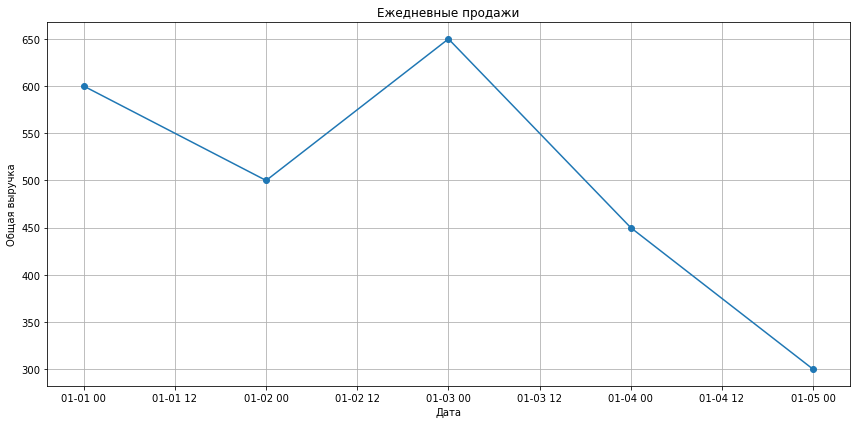

In [46]:
# Визуализация результатов
# Преобразование Spark DataFrame в Pandas DataFrame для визуализации
daily_sales_pd = daily_sales.toPandas()
daily_sales_pd['date'] = pd.to_datetime(daily_sales_pd['date'])

plt.figure(figsize=(12, 6))
plt.plot(daily_sales_pd['date'], daily_sales_pd['total_revenue'], marker='o')
plt.title('Ежедневные продажи')
plt.xlabel('Дата')
plt.ylabel('Общая выручка')
plt.grid(True)
plt.tight_layout()
plt.show()

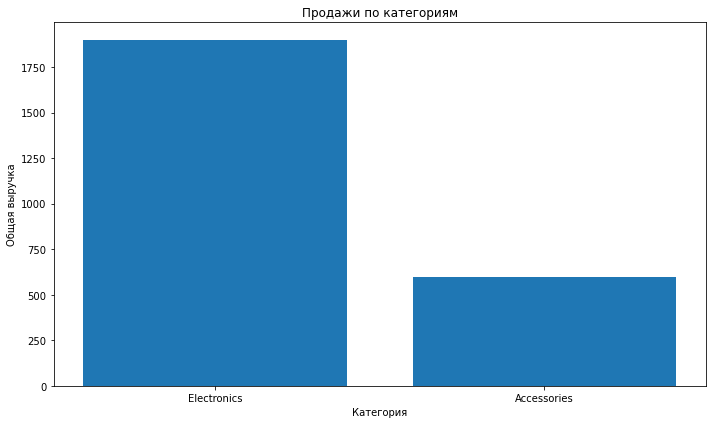

In [47]:
category_sales_pd = category_sales.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(category_sales_pd['category'], category_sales_pd['total_revenue'])
plt.title('Продажи по категориям')
plt.xlabel('Категория')
plt.ylabel('Общая выручка')
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

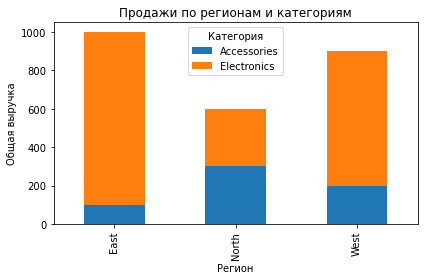

In [48]:
region_category_sales_pd = region_category_sales.toPandas()

# Создание сводной таблицы для визуализации
pivot_df = region_category_sales_pd.pivot(index='region', columns='category', values='total_revenue')
pivot_df.fillna(0, inplace=True)

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', stacked=True)
plt.title('Продажи по регионам и категориям')
plt.xlabel('Регион')
plt.ylabel('Общая выручка')
plt.legend(title='Категория')
plt.tight_layout()
plt.show()

### Пример 2: JOIN-операции в Spark SQL




In [49]:

# Создание файла с данными для JDBC
customer_data = """
customer_id,customer_name,email,registration_date,status
1,John Smith,john.smith@example.com,2022-01-15,active
2,Alice Brown,alice.brown@example.com,2022-02-20,active
3,Robert Johnson,robert.j@example.com,2022-03-10,inactive
4,Emily Davis,emily.davis@example.com,2022-01-30,active
5,Michael Wilson,michael.w@example.com,2022-04-05,active
"""

with open("customers.csv", "w") as f:
    f.write(customer_data)

In [52]:
!hadoop fs -put -f customers.csv /user/ubuntu/customers.csv

In [53]:
# Чтение данных в DataFrame
customers_df = spark.read.csv("customers.csv", header=True, inferSchema=True)
customers_df.createOrReplaceTempView("customers")


In [ ]:
# Демонстрация запроса, объединяющего данные из нескольких источников
complex_query = spark.sql("""
SELECT 
    c.customer_name,
    c.status,
    s.date,
    p.product_name,
    s.quantity,
    s.revenue,
    st.store_name,
    st.region
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN stores st ON s.store_id = st.store_id
JOIN customers c ON c.customer_id = s.store_id 
WHERE c.status = 'active'
ORDER BY s.date, c.customer_name
""")

complex_query.show()

+-------------+------+----------+------------+--------+-------+--------------+------+
|customer_name|status|      date|product_name|quantity|revenue|    store_name|region|
+-------------+------+----------+------------+--------+-------+--------------+------+
|  Alice Brown|active|2023-01-01|      Laptop|       4|  200.0|    Mall Store|  West|
|   John Smith|active|2023-01-01|      Laptop|       5|  250.0|Downtown Store|  East|
|   John Smith|active|2023-01-01|  Smartphone|       3|  150.0|Downtown Store|  East|
|  Alice Brown|active|2023-01-02|  Smartphone|       5|  250.0|    Mall Store|  West|
|   John Smith|active|2023-01-02|  Headphones|       2|  100.0|Downtown Store|  East|
|  Alice Brown|active|2023-01-03|  Headphones|       4|  200.0|    Mall Store|  West|
|   John Smith|active|2023-01-03|      Laptop|       6|  300.0|Downtown Store|  East|
|  Alice Brown|active|2023-01-04|      Laptop|       5|  250.0|    Mall Store|  West|
|   John Smith|active|2023-01-04|  Smartphone|       4

In [56]:
# Сохранение результатов запроса
complex_query.write.mode("overwrite").csv("query_results.csv")
complex_query.write.mode("overwrite").json("query_results.json")
complex_query.write.mode("overwrite").parquet("query_results.parquet")

In [55]:
# Запись в другую SQL-таблицу
complex_query.write.mode("overwrite").saveAsTable("company.query_results")

In [ ]:
# Очистка после работы
!rm employees.csv
!rm departments.csv
!rm sales.csv
!rm stores.csv
!rm products.csv
!rm customers.csv

In [ ]:
# Остановка SparkSession
spark.stop()

print("Spark SQL практика завершена!")